# Case Studies: Case Study 3; Inaccurate continuum limit

This example shows how we obtained the results in the paper for the
third case study, for the case that the continuum limit is inaccurate.
Let us load in the packages we will need.

In [1]:
using StepwiseEQL
using CairoMakie
using EpithelialDynamics1D
using OrdinaryDiffEq
using Random

## Simulating
We start by simulating the results.

In [2]:
final_time = 75.0
domain_length = 30.0
midpoint = domain_length / 2
initial_condition = [LinRange(0, 5, 30); LinRange(25, 30, 30)] |> unique!
damping_constant = 1.0
resting_spring_length = 0.2
spring_constant = 1 / 5
k = spring_constant
force_law_parameters = (s=resting_spring_length, k=spring_constant)
force_law = (δ, p) -> p.k * (p.s - δ)
Δt = 1e-2
K = 15.0
β = 0.15
G = (δ, p) -> p.β * (one(δ) - inv(p.K * δ))
Gp = (β=β, K=K)
prob = CellProblem(;
    final_time,
    initial_condition,
    damping_constant,
    force_law,
    force_law_parameters,
    proliferation_law=G,
    proliferation_period=Δt,
    proliferation_law_parameters=Gp)
ens_prob = EnsembleProblem(prob)
Random.seed!(292919)
esol = solve(ens_prob, Tsit5(), EnsembleSerial(); trajectories=1000, saveat=0.1)

EnsembleSolution Solution of length 1000 with uType:
SciMLBase.ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, SciMLBase.ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, EpithelialDynamics1D.CellProblem{Main.var"##2727".var"#1#2", NamedTuple{(:s, :k), Tuple{Float64, Float64}}, Main.var"##2727".var"#3#4", NamedTuple{(:β, :K), Tuple{Float64, Float64}}}, SciMLBase.ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, EpithelialDynamics1D.CellProblem{Main.var"##2727".var"#1#2", NamedTuple{(:s, :k), Tuple{Float64, Float64}}, Main.var"##2727".var"#3#4", NamedTuple{(:β, :K), Tuple{Float64, Float64}}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag

## Equation learning
We now learn the equations.

In [3]:
diffusion_basis = PolynomialBasis(-1, -3)
reaction_basis = PolynomialBasis(1, 5)
eql_sol = stepwise_selection(esol; diffusion_basis, reaction_basis,
    threshold_tol=(q=0.25,), mesh_points=1000,
    initial=:none, num_knots=200)

StepwiseEQL Solution.
    D(q) = θ₂ᵈ ϕ₂ᵈ(q)
    R(q) = θ₁ʳ ϕ₁ʳ(q) + θ₂ʳ ϕ₂ʳ(q) + θ₃ʳ ϕ₃ʳ(q) + θ₄ʳ ϕ₄ʳ(q)
┌──────┬──────────────────┬────────────────────────────────────────┬───────┐
│ Step │  θ₁ᵈ   θ₂ᵈ   θ₃ᵈ │  θ₁ʳ    θ₂ʳ       θ₃ʳ        θ₄ʳ   θ₅ʳ │  Loss │
├──────┼──────────────────┼────────────────────────────────────────┼───────┤
│    1 │ 0.00  0.00  0.00 │ 0.00   0.00      0.00       0.00  0.00 │ -0.33 │
│    2 │ 0.00  0.00  0.00 │ 0.02   0.00      0.00       0.00  0.00 │  0.51 │
│    3 │ 0.00  0.00  0.00 │ 0.11  -0.01      0.00       0.00  0.00 │  0.20 │
│    4 │ 0.00  0.11  0.00 │ 0.11  -0.01      0.00       0.00  0.00 │ -0.04 │
│    5 │ 0.00  0.12  0.00 │ 0.13  -0.01  1.59e-04       0.00  0.00 │ -0.46 │
│    6 │ 0.00  0.12  0.00 │ 0.16  -0.02  7.49e-04  -1.69e-05  0.00 │ -1.13 │
└──────┴──────────────────┴────────────────────────────────────────┴───────┘


## Plotting
We plot the results as follows. To improve the plot visually,
we need to recompute the `AveragedODESolution` so that there are more
knots.

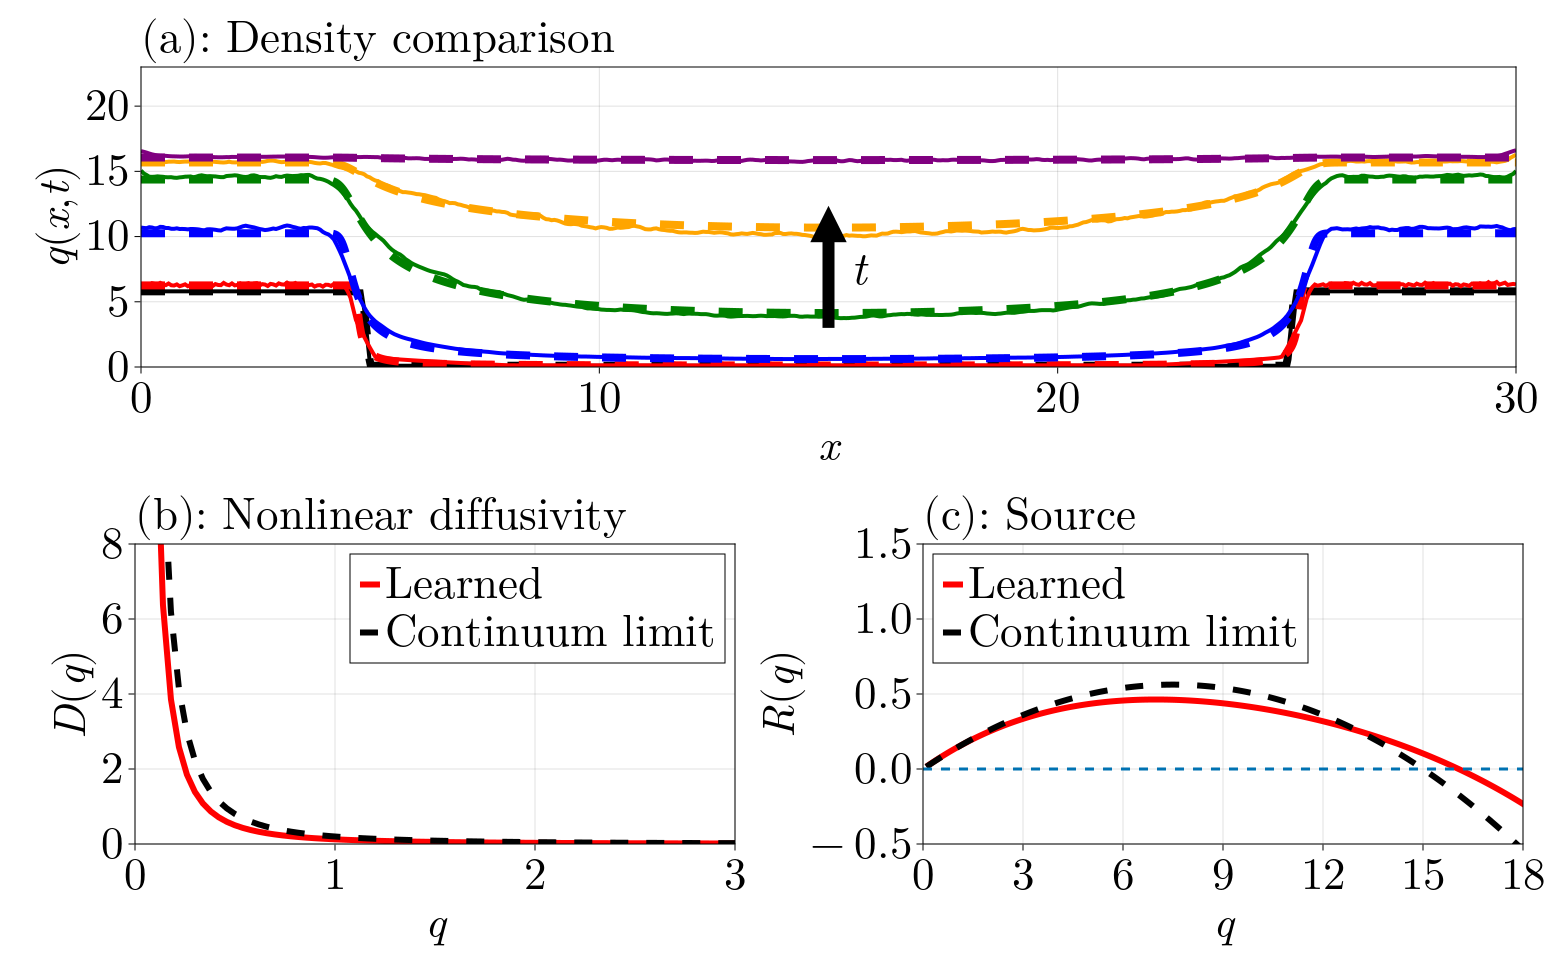

In [4]:
avg_sol = AveragedODESolution(esol, 500)
fig = Figure(fontsize=45, resolution=(1550, 961))
ax = Axis(fig[1, 1:2], xlabel=L"x", ylabel=L"q(x, t)",
    width=1375, height=300,
    title=L"(a):$ $ Density comparison", titlealign=:left,
    xticks=(0:10:30, [L"%$s" for s in 0:10:30]),
    yticks=(0:5:20, [L"%$s" for s in 0:5:20]))
t = (0, 1, 10, 25, 40, 75)
colors = (:black, :red, :blue, :green, :orange, :purple)
time_indices = [findlast(≤(τ), esol[1].t) for τ in t]
for (j, i) in enumerate(time_indices)
    lines!(ax, eql_sol.pde.geometry.mesh_points, eql_sol.pde_sol.u[i], color=colors[j], linestyle=:dash, linewidth=8)
    lines!(ax, avg_sol.u[i], avg_sol.q[i], color=colors[j], linewidth=4, label=L"%$(t[j])")
end
arrows!(ax, [15.0], [3.0], [0.0], [7.5], color=:black, linewidth=12, arrowsize=50)
text!(ax, [15.5], [5.7], text=L"t", color=:black, fontsize=47)
xlims!(ax, 0, 30)
ylims!(ax, 0, 23)
ax2 = Axis(fig[2, 1],xlabel=L"q",ylabel=L"D(q)",
    width=600,height=300,
title=L"(b):$ $ Nonlinear diffusivity",titlealign=:left,
    xticks=(0:1:3, [L"%$s" for s in 0:1:3]),
    yticks=(0:2:8, [L"%$s" for s in 0:2:8]))
q_range = LinRange(1 / 10, 20, 500)
D_cont_fnc = q -> (force_law_parameters.k / damping_constant) / q^2
R_cont_fnc = q -> β * q * (1 - q / K)
D_sol = diffusion_basis.(q_range, Ref(eql_sol.diffusion_theta), Ref(nothing))
R_sol = reaction_basis.(q_range, Ref(eql_sol.reaction_theta), Ref(nothing))
D_cont = D_cont_fnc.(q_range)
R_cont = R_cont_fnc.(q_range)
lines!(ax2, q_range, D_sol, linewidth=6, color=:red, linestyle=:solid, label=L"$ $Learned")
lines!(ax2, q_range, D_cont, linewidth=6, color=:black, linestyle=:dash, label=L"$ $Continuum limit")
axislegend(position=:rt)
ax3 = Axis(fig[2, 2], xlabel=L"q", ylabel=L"R(q)",
    width=600, height=300,
    title=L"(c):$ $ Source",titlealign=:left,
    xticks=(0:3:18, [L"%$s" for s in 0:3:20]),
    yticks=(-0.5:0.5:1.5, [L"%$s" for s in -0.5:0.5:1.5]))
lines!(ax3, q_range, R_sol, linewidth=6, color=:red, linestyle=:solid, label=L"$ $Learned")
lines!(ax3, q_range, R_cont, linewidth=6, color=:black, linestyle=:dash, label=L"$ $Continuum limit")
hlines!(ax3, [0.0], linecolor=:grey, linewidth=3, linestyle=:dash)
axislegend(position=:lt)
ylims!(ax2, 0, 8)
ylims!(ax3, -0.5, 1.5)
xlims!(ax2, 0, 3)
xlims!(ax3, 0, 18)
fig

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*